# Simple predictions fitted on hour and distance

This notebook creates two new features for the taxi database set, culls outliers, fits a gradient boosted regressor to the data. 

With 200 trees, it generates a prediction in the to 62%. Note, I have trees set to 50 for a quicker first run of the notebook.

This is my first kernel and and so thank you for checking it out. Constructive criticism is welcome.

# I. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
train = pd.read_csv('train.csv') #change to '../input/train.csv' for kaggle upload
test = pd.read_csv('test.csv') #change to '../input/test.csv' for kaggle upload
sample_submission = pd.read_csv('sample_submission.csv') #change to '../input/sample_submission.csv' for kaggle upload

# II. Data Overview

In [182]:
train.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,455


In [183]:
test.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.75668,N


In [184]:
sample_submission.head(1)

,id,trip_duration
0,id3004672,959


In [185]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [186]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [187]:
len(train)

1458644

In [188]:
len(test)

625134

In [189]:
# Extra features in train (which are note present in test)
[column for column in train.columns if column not in test.columns]

['dropoff_datetime', 'trip_duration']

# III. Cleaning

In [190]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [191]:
train[train.isnull().any(axis=1)] #No missing values

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [5]:
def remove_outliers(old_df,number_of_std,columns="All",skip="None"):
    """
    Removes outliers from a dataframe.
    
    Parameters:
    old_df: Series or dataframe
    
    number_of_std: Number of standard deviations for threshhold. 
                   Function will remove all outliers beyond this many standard deviations.
                   
    columns: The columns upon which the operation will be performed. (List of column names)
    
    skip: List of columns to be skipped.
    
    Returns:
    A dataframe with the outliers removed.
    
    """
    
    if isinstance(old_df,pd.core.series.Series): #If series passed, then only 
        current_series = old_df #set current series
        
        mean = np.mean(current_series)    #Mean
        std = np.std(current_series)      #Std
        threshold = number_of_std*std     #Threshhold = number of std * std
        
        new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from series
    else:
        if columns=="All": #Set columns
            columns=old_df.columns
            
        if skip!="None": #Skip any columns to be skipped
            columns = columns-skip
        
        for column in columns:
            current_series = old_df[column] #Iterate through each column

            mean = np.mean(current_series) #Set up threshold for which x should be within
            std = np.std(current_series)
            threshold = number_of_std*std

            new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from this column
    
    return new_df

In [193]:
#Remove outlier trips (in case length was caused by unusual circumstances)
#Outlier here defined as points more than 4 standard deviations from the mean (approx 0.3%)
#train = remove_outliers(train,4,columns=['trip_duration']) 

In [6]:
train = remove_outliers(train,4,columns=['trip_duration','pickup_longitude','pickup_latitude', 'dropoff_longitude','dropoff_latitude']) 

***
# IV. Feature Engineering

Feature engineering:
- Direct Distance (as the crow flies)
- Manhattan distance
- Hour, month, and day of the week of departure
- Weekend boolean variable

### FE 1: 'dist' (distance travelled)

In [7]:
train['dist'] = np.sqrt((train['pickup_latitude']-train['dropoff_latitude'])**2 
                         + (train['pickup_longitude']-train['dropoff_longitude'])**2) 

test['dist'] = np.sqrt((test['pickup_latitude']-test['dropoff_latitude'])**2 
                         + (test['pickup_longitude']-test['dropoff_longitude'])**2) 

# FE 2: 'manh' (manhattan distance)

In [8]:
train['manh'] = abs(train['pickup_latitude']-train['dropoff_latitude']) + abs(train['pickup_longitude']-train['dropoff_longitude'])

test['manh'] = abs(test['pickup_latitude']-test['dropoff_latitude']) + abs(test['pickup_longitude']-test['dropoff_longitude'])

### FE 3: 'hour' (hour picked up), 'month, and 'dayofweek' (day of the week picked up)

In [9]:
#Convert to datetime
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [10]:
#Hour
train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

#Day of the week
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek

#Month
train['month'] = train['pickup_datetime'].dt.month
test['month'] = test['pickup_datetime'].dt.month

# FE 4: 'weekend'

In [11]:
train['weekend']=train['dayofweek'].apply(lambda x: 1 if x>5 else 0)
test['weekend']=test['dayofweek'].apply(lambda x: 1 if x>5 else 0)

# FE 5: PCA of longtitude and latitude

In [ ]:
#To complete for a later attempt

***
# V. Visualization

(0, 5000)

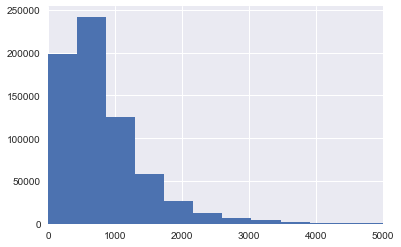

In [22]:
plt.figure()
train[train['vendor_id']==1]['trip_duration'].hist(bins=40)
plt.xlim(0,5000)

(0, 5000)

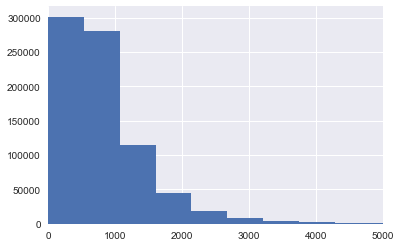

In [23]:
plt.figure()
train[train['vendor_id']==2]['trip_duration'].hist(bins=40)
plt.xlim(0,5000)

C:\Users\Josh\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


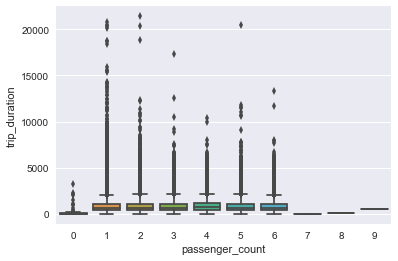

In [24]:
#plt.scatter(x=train['passenger_count'],y=train['trip_duration'])
sns.boxplot(x='passenger_count',y='trip_duration',data=train)

In [25]:
#train[['hour','dist','trip_duration']].corr()

In [26]:
#sns.barplot(x='hour',y='trip_duration',data=train)

# VI. Feature Selection

In [121]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'dist', 'manh', 'hour', 'dayofweek', 'month',
       'weekend'],
      dtype='object')

In [12]:
features= ['dist', 'manh', 'hour', 'dayofweek', 'month', 'weekend','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

In [13]:
X = train[features]
y = train['trip_duration']

X_final = test[features]

***
# VI. Fitting and predicting

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Model: Gradient Boosting Regressor

In [57]:
gm = GradientBoostingRegressor(n_estimators=5) 
#Change n_estimators to a higher number (e.g. 100, 150 or 200) for a more accurate score
#Note: it takes a long time to run with a higher number of estimators.

gm.fit(X_train,y_train)

gm.score(X_test,y_test)

0.40295472958427225

In [ ]:
gm.fit(X,y)

gm_pred = gm.pred(X_final)

In [ ]:
gm_pred[gm_pred<0]

In [ ]:
#quick fix until I figure out how to make gm_pred[gm_pred<0] empty

gm_pred[gm_pred<0]=2

## Model: Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [212]:
len(X)

1395863

In [213]:
len(y)

1395863

In [214]:
rfc = RandomForestRegressor(n_estimators=10, min_samples_leaf=100, oob_score=True,n_jobs=-1)

rfc.fit(X_train,y_train)

rfc.oob_score_

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:720: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.0094586326167410695

In [215]:
rfc.score(X_test,y_test)

0.0034658340510922425

In [216]:
rfc = RandomForestRegressor(n_estimators=50, min_samples_leaf=100, oob_score=True,n_jobs=-1)

rfc.fit(X,y)

rfc.oob_score_

KeyboardInterrupt: 

In [163]:
rfc = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, oob_score=True,n_jobs=-1)

rfc.fit(X,y)

rfc.oob_score_

0.7681900370447533

In [167]:
rfc_pred = rfc.predict(X_final)

#### Grid Search on RFC

In [37]:
from sklearn.model_selection import GridSearchCV

In [70]:
param_grid = [{'n_estimators':[20],'max_features':[2,4,6]}]

# {'boostrap':[False],'n_estimators':[1,2,5],'max_features':[2,4,6]}

In [71]:
rfc = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(rfc, param_grid, cv=5,scoring='neg_mean_squared_error',verbose=1)

In [72]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 16.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [20], 'max_features': [2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [73]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 20}

In [87]:
"""
param_grid = [{'n_estimators':[100,200],'max_features':[2,4],'min_samples_split':[10000,100]}]

rfc = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(rfc, param_grid, cv=5,scoring='neg_mean_squared_error',verbose=3)

grid_search.fit(X,y)
"""

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] max_features=4, min_samples_split=10000, n_estimators=20 ........
[CV]  max_features=4, min_samples_split=10000, n_estimators=20, score=-145397.81951146794, total=   9.5s
[CV] max_features=4, min_samples_split=10000, n_estimators=20 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV]  max_features=4, min_samples_split=10000, n_estimators=20, score=-141882.87451954122, total=   9.6s
[CV] max_features=4, min_samples_split=10000, n_estimators=20 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.3s remaining:    0.0s


[CV]  max_features=4, min_samples_split=10000, n_estimators=20, score=-135489.92620572716, total=  10.6s
[CV] max_features=4, min_samples_split=10000, n_estimators=20 ........
[CV]  max_features=4, min_samples_split=10000, n_estimators=20, score=-139505.99966225444, total=   9.6s
[CV] max_features=4, min_samples_split=10000, n_estimators=20 ........
[CV]  max_features=4, min_samples_split=10000, n_estimators=20, score=-144286.09013394095, total=  10.0s
[CV] max_features=4, min_samples_split=100, n_estimators=20 ..........
[CV]  max_features=4, min_samples_split=100, n_estimators=20, score=-128119.48116711227, total=  16.6s
[CV] max_features=4, min_samples_split=100, n_estimators=20 ..........
[CV]  max_features=4, min_samples_split=100, n_estimators=20, score=-125489.77613846741, total=  16.9s
[CV] max_features=4, min_samples_split=100, n_estimators=20 ..........
[CV]  max_features=4, min_samples_split=100, n_estimators=20, score=-118535.52072299385, total=  16.4s
[CV] max_features=4, 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [20], 'max_features': [4], 'min_samples_split': [10000, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=3)

In [89]:
#best_params = grid_search.best_params_

In [96]:
grid_search.best_params_

{'max_features': 4, 'min_samples_split': 100, 'n_estimators': 20}

#### RFC Prediction

In [169]:
best_params = {'max_features': 4, 'min_samples_split': 100} #Overwrite since grid search won't be run everytime

In [173]:
rfc = RandomForestRegressor(**best_params)

rfc.set_params(n_jobs=-1,n_estimators=100,oob_score=True)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [174]:
rfc.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [175]:
rfc.oob_score_

0.77928409506249174

In [110]:
#rfc.fit(X_train,y_train)
#rfc.score(X_test,y_test)

## Model: First time XGBoost!

In [16]:
import xgboost as xgb

#### Grid Search XGBoost

In [89]:
#param_grid = [{'min_child_weight':[1,10],'max_depth':[3,6,10]}]

#xgbr = XGBRegressor(n_jobs=-1)

#grid_search = GridSearchCV(xgbr, param_grid, cv=3,verbose=3)

#grid_search.fit(X,y)

print("Best was max_child_weight=10 and max_depth=10")

Best was max_child_weight=10 and max_depth=10


In [74]:
#grid_search.best_params_

{'max_depth': 10, 'min_child_weight': 10}

In [75]:
#grid_search.best_score_

0.72264883257913293

In [21]:
parameters = {'max_depth': 10, 'min_child_weight': 10}

In [141]:
"""
param_grid = [{'min_child_weight':[10],'max_depth':[10]}]

xgbr = XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(xgbr, param_grid, cv=2,verbose=3)

grid_search.fit(X,y)
"""

"\nparam_grid = [{'min_child_weight':[10],'max_depth':[10]}]\n\nxgbr = XGBRegressor(n_jobs=-1)\n\ngrid_search = GridSearchCV(xgbr, param_grid, cv=2,verbose=3)\n\ngrid_search.fit(X,y)\n"

#### Training XGBoost

In [17]:
import xgboost as xgb

In [23]:
y_log = np.log(y + 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X.values,y_log, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

dfinal = xgb.DMatrix(X_final.values)
watchlist = [(dtrain,'dtrain'),(dtest,'dtest')]

In [27]:
xgbr = xgb.train(params=parameters,
                 dtrain=dtrain,
                 num_boost_round=80,
                 evals=watchlist,
                 early_stopping_rounds=30,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:4.22491	dtest-rmse:4.2259
Multiple eval metrics have been passed: 'dtest-rmse' will be used for early stopping.

Will train until dtest-rmse hasn't improved in 30 rounds.
[10]	dtrain-rmse:0.425804	dtest-rmse:0.436509
[20]	dtrain-rmse:0.392838	dtest-rmse:0.41195
[30]	dtrain-rmse:0.384467	dtest-rmse:0.408693
[40]	dtrain-rmse:0.375459	dtest-rmse:0.404799
[50]	dtrain-rmse:0.372093	dtest-rmse:0.404553
[60]	dtrain-rmse:0.366525	dtest-rmse:0.40311
[70]	dtrain-rmse:0.362945	dtest-rmse:0.402879
[79]	dtrain-rmse:0.360851	dtest-rmse:0.402739


In [226]:
xgbr = xgb.train(params=parameters,
                 dtrain=dtrain,
                 num_boost_round=80,
                 evals=watchlist,
                 early_stopping_rounds=30,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:4.20164	dtest-rmse:4.20313
Multiple eval metrics have been passed: 'dtest-rmse' will be used for early stopping.

Will train until dtest-rmse hasn't improved in 30 rounds.
[10]	dtrain-rmse:0.425819	dtest-rmse:0.435584
[20]	dtrain-rmse:0.391942	dtest-rmse:0.410055
[30]	dtrain-rmse:0.381999	dtest-rmse:0.406306
[40]	dtrain-rmse:0.374321	dtest-rmse:0.403478
[50]	dtrain-rmse:0.368479	dtest-rmse:0.402326
[60]	dtrain-rmse:0.36462	dtest-rmse:0.401998
[70]	dtrain-rmse:0.360603	dtest-rmse:0.400772
[79]	dtrain-rmse:0.35546	dtest-rmse:0.400122


In [158]:
xgbr = xgb.train(params=parameters,
                 dtrain=dtrain,
                 evals=watchlist,
                 early_stopping_rounds=10,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:787.282	dtest-rmse:785.986
Multiple eval metrics have been passed: 'dtest-rmse' will be used for early stopping.

Will train until dtest-rmse hasn't improved in 10 rounds.
[9]	dtrain-rmse:313.092	dtest-rmse:320.629


In [154]:
xgbr = xgb.train(params=parameters,
                 dtrain=dtrain,
                 num_boost_round=60,
                 evals=watchlist,
                 early_stopping_rounds=10,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:787.282	dtest-rmse:785.986
Multiple eval metrics have been passed: 'dtest-rmse' will be used for early stopping.

Will train until dtest-rmse hasn't improved in 10 rounds.
[10]	dtrain-rmse:310.223	dtest-rmse:318.639
[20]	dtrain-rmse:293.869	dtest-rmse:308.384
[30]	dtrain-rmse:290.744	dtest-rmse:307.396
[40]	dtrain-rmse:287.939	dtest-rmse:306.062
[50]	dtrain-rmse:285.034	dtest-rmse:305.335
[59]	dtrain-rmse:282.288	dtest-rmse:304.637


#### Feature Importance XGB

In [227]:
feature_importance_dict = xgbr.get_fscore()
fs = ['f%i' % i for i in range(len(features))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
feature_importance = f1
feature_importance = feature_importance.fillna(0)

feature_importance[['f', 'importance']].sort_values(by='importance', ascending=False)

,f,importance
1,f6,6059
2,f7,5918
6,f9,5575
7,f8,5366
0,f0,4982
5,f1,3404
4,f2,3212
3,f3,1719
8,f4,1155


In [28]:
xgbr.best_score

0.402619

In [165]:
xgbr.best_score #Without log

303.513397

#### XGBoost Predction

In [29]:
xgb_pred = xgbr.predict(dfinal)

In [30]:
xgb_pred = np.exp(xgb_pred) - 1

In [31]:
xgb_pred.mean()

807.25439

In [32]:
train['trip_duration'].mean()

956.887730497136

***
# X. Exporting submission_df

Prediction options:
- gm_pred
- rfc_pred
- xgb_pred

In [33]:
submission_pred = xgb_pred
submission_name = 'xgboost with log transformation.csv' 

In [35]:
submission_pred[submission_pred<0] #Check for invalid submission values

array([], dtype=float32)

In [151]:
submission_pred[submission_pred<0]=1 #Correct for negative lengths

In [36]:
submission_df = pd.DataFrame(submission_pred,index=test['id'],columns=['trip_duration']).reset_index()

submission_df.to_csv(submission_name,index=False)

***
# Thank you for checking out this kernel.

Ideas: for future exploration - day of the week, regions.

# Notes from other tutorials

For parameter tuning I prefer random search. Usually I try different values for the following parameters

- min_child_weight
- eta
- colsample_bytree
- max_depth
- subsample
- lambda

I like sklearn CV options (RandomizedSearchCV or GridSearchCV) however for usual competitions the training for a single model could take hours and I like to save the intermediate results (performance metric, oof predictions etc.) so I use custom search. Based on the results I like to set the grid searchpoints manually. A simple random parameter search would be

In [132]:
#xgbr = xgb.train(params=xgb_pars,dtrain=dtrain,num_boost_round=60,early_stopping_rounds=10,maximize=False,verbose_eval=10)

In [47]:
"""
xgb = XGBRegressor()

parameters = {
        'num_boost_round': [100, 250, 500],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [6, 9, 12],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }

clf = GridSearchCV(xgb, parameters, n_jobs=1, cv=2,verbose=3)
"""

In [106]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [45]:
"""
xgb = XGBRegressor()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb, parameters, n_jobs=-1, cv=3, scoring='roc_auc',verbose=2, refit=True)

clf.fit(X_train, y_train)
"""

Fitting 3 folds for each of 1 candidates, totalling 3 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Josh\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Josh\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001D02285BC90, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Josh\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\J...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001D02285BC90, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Josh\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\J...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 15, 18, 53, 25, 235533, tzinfo=datetime.timezone.utc), 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'session': '5260C41D777F4040BA2A47C999CD67D8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'5260C41D777F4040BA2A47C999CD67D8']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 15, 18, 53, 25, 235533, tzinfo=datetime.timezone.utc), 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'session': '5260C41D777F4040BA2A47C999CD67D8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'5260C41D777F4040BA2A47C999CD67D8'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 9, 15, 18, 53, 25, 235533, tzinfo=datetime.timezone.utc), 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'session': '5260C41D777F4040BA2A47C999CD67D8', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'F3BF21FA33224869AAD355AFF5B363D3', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='xgb = XGBRegressor()\n\n#brute force scan for all ...verbose=2, refit=True)\n\nclf.fit(X_train, y_train)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-45-f130e4046d35>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1d0465b0cc0, executio..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001D02AC86420, file "<ipython-input-45-f130e4046d35>", line 24>
        result = <ExecutionResult object at 1d0465b0cc0, executio..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001D02AC86420, file "<ipython-input-45-f130e4046d35>", line 24>, result=<ExecutionResult object at 1d0465b0cc0, executio..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001D02AC86420, file "<ipython-input-45-f130e4046d35>", line 24>
        self.user_global_ns = {'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma...t as xgb\nget_ipython().magic('matplotlib inline')", "import pandas as pd\nimport numpy as np\nimport ma...t as xgb\nget_ipython().magic('matplotlib inline')", 'from sklearn.model_selection import train_test_s...sklearn.ensemble import GradientBoostingRegressor', "train = pd.read_csv('train.csv') #change to '../...../input/sample_submission.csv' for kaggle upload", 'train.head(1)', 'test.head(1)', 'sample_submission.head(1)', 'train.columns', 'test.columns', 'len(train)', 'len(test)', '# Extra features in train (which are note presen...n in train.columns if column not in test.columns]', 'train.isnull().sum()', 'train[train.isnull().any(axis=1)] #No missing values', 'def remove_outliers(old_df,number_of_std,columns... outliers from this column\n    \n    return new_df', "#Remove outlier trips (in case length was caused...move_outliers(train,4,columns=['trip_duration']) ", "train['dist'] = np.sqrt((train['pickup_latitude'...ickup_longitude']-test['dropoff_longitude'])**2) ", "train['manh'] = abs(train['pickup_latitude']-tra...st['pickup_longitude']-test['dropoff_longitude'])", "#Convert to datetime\ntrain['pickup_datetime'] = ...etime'] = pd.to_datetime(test['pickup_datetime'])", ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {5:           id  vendor_id      pickup_datetime    ...    40.765602                  N            455  , 6:           id  vendor_id      pickup_datetime  pa...  

  store_and_fwd_flag  
0                  N  , 7:           id  trip_duration
0  id3004672            959, 8: Index(['id', 'vendor_id', 'pickup_datetime', 'dr...',
       'trip_duration'],
      dtype='object'), 9: Index(['id', 'vendor_id', 'pickup_datetime', 'pa...de', 'store_and_fwd_flag'],
      dtype='object'), 10: 1458644, 11: 625134, 12: ['dropoff_datetime', 'trip_duration'], 13: id                    0
vendor_id             0
...wd_flag    0
trip_duration         0
dtype: int64, 14: Empty DataFrame
Columns: [id, vendor_id, pickup_...ude, store_and_fwd_flag, trip_duration]
Index: [], ...}, 'X':              dist      manh  hour  dayofweek  mo...    1      4        0

[1456583 rows x 6 columns], 'XGBRegressor': <class 'xgboost.sklearn.XGBRegressor'>, 'X_final':             dist      manh  hour  dayofweek  mon...     4      1        0

[625134 rows x 6 columns], 'X_test':              dist      manh  hour  dayofweek  mo...     2      6        0

[291317 rows x 6 columns], 'X_train':              dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], ...}
        self.user_ns = {'GradientBoostingRegressor': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import pandas as pd\nimport numpy as np\nimport ma...t as xgb\nget_ipython().magic('matplotlib inline')", "import pandas as pd\nimport numpy as np\nimport ma...t as xgb\nget_ipython().magic('matplotlib inline')", 'from sklearn.model_selection import train_test_s...sklearn.ensemble import GradientBoostingRegressor', "train = pd.read_csv('train.csv') #change to '../...../input/sample_submission.csv' for kaggle upload", 'train.head(1)', 'test.head(1)', 'sample_submission.head(1)', 'train.columns', 'test.columns', 'len(train)', 'len(test)', '# Extra features in train (which are note presen...n in train.columns if column not in test.columns]', 'train.isnull().sum()', 'train[train.isnull().any(axis=1)] #No missing values', 'def remove_outliers(old_df,number_of_std,columns... outliers from this column\n    \n    return new_df', "#Remove outlier trips (in case length was caused...move_outliers(train,4,columns=['trip_duration']) ", "train['dist'] = np.sqrt((train['pickup_latitude'...ickup_longitude']-test['dropoff_longitude'])**2) ", "train['manh'] = abs(train['pickup_latitude']-tra...st['pickup_longitude']-test['dropoff_longitude'])", "#Convert to datetime\ntrain['pickup_datetime'] = ...etime'] = pd.to_datetime(test['pickup_datetime'])", ...], 'LinearRegression': <class 'sklearn.linear_model.base.LinearRegression'>, 'Out': {5:           id  vendor_id      pickup_datetime    ...    40.765602                  N            455  , 6:           id  vendor_id      pickup_datetime  pa...  

  store_and_fwd_flag  
0                  N  , 7:           id  trip_duration
0  id3004672            959, 8: Index(['id', 'vendor_id', 'pickup_datetime', 'dr...',
       'trip_duration'],
      dtype='object'), 9: Index(['id', 'vendor_id', 'pickup_datetime', 'pa...de', 'store_and_fwd_flag'],
      dtype='object'), 10: 1458644, 11: 625134, 12: ['dropoff_datetime', 'trip_duration'], 13: id                    0
vendor_id             0
...wd_flag    0
trip_duration         0
dtype: int64, 14: Empty DataFrame
Columns: [id, vendor_id, pickup_...ude, store_and_fwd_flag, trip_duration]
Index: [], ...}, 'X':              dist      manh  hour  dayofweek  mo...    1      4        0

[1456583 rows x 6 columns], 'XGBRegressor': <class 'xgboost.sklearn.XGBRegressor'>, 'X_final':             dist      manh  hour  dayofweek  mon...     4      1        0

[625134 rows x 6 columns], 'X_test':              dist      manh  hour  dayofweek  mo...     2      6        0

[291317 rows x 6 columns], 'X_train':              dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Users\Josh\Documents\Kaggle\taxi\<ipython-input-45-f130e4046d35> in <module>()
     19               'seed': [1337]}
     20 
     21 
     22 clf = GridSearchCV(xgb, parameters, n_jobs=-1, cv=3, scoring='roc_auc',verbose=2, refit=True)
     23 
---> 24 clf.fit(X_train, y_train)

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=3, error_score='raise',
       e..._score=True,
       scoring='roc_auc', verbose=2), X=             dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], y=438841     1124
408043     1249
890675      528
...ame: trip_duration, Length: 1165266, dtype: int64, groups=None, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =              dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns]
        y = 438841     1124
408043     1249
890675      528
...ame: trip_duration, Length: 1165266, dtype: int64
        groups = None
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Sep 15 11:53:27 2017
PID: 7944                  Python 3.6.1: C:\Users\Josh\Anaconda3\python.exe
...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8),              dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], 438841     1124
408043     1249
890675      528
...ame: trip_duration, Length: 1165266, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([ 388422,  388423,  388424, ..., 1165263, 1165264, 1165265]), memmap([     0,      1,      2, ..., 388419, 388420, 388421]), 2, {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1, 'nthread': 4, 'seed': 1337, 'silent': 1, 'subsample': 0.8}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8),              dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], 438841     1124
408043     1249
890675      528
...ame: trip_duration, Length: 1165266, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, memmap([ 388422,  388423,  388424, ..., 1165263, 1165264, 1165265]), memmap([     0,      1,      2, ..., 388419, 388420, 388421]), 2, {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1, 'nthread': 4, 'seed': 1337, 'silent': 1, 'subsample': 0.8})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8), X=             dist      manh  hour  dayofweek  mo...    0      2        0

[1165266 rows x 6 columns], y=438841     1124
408043     1249
890675      528
...ame: trip_duration, Length: 1165266, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=memmap([ 388422,  388423,  388424, ..., 1165263, 1165264, 1165265]), test=memmap([     0,      1,      2, ..., 388419, 388420, 388421]), verbose=2, parameters={'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1, 'nthread': 4, 'seed': 1337, 'silent': 1, 'subsample': 0.8}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    462                              " make sure that it has been spelled correctly.)")
    463 
    464     else:
    465         fit_time = time.time() - start_time
    466         # _score will return dict if is_multimetric is True
--> 467         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8)
        X_test =              dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns]
        y_test = 438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    468         score_time = time.time() - start_time - fit_time
    469         if return_train_score:
    470             train_scores = _score(estimator, X_train, y_train, scorer,
    471                                   is_multimetric)

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8), X_test=             dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns], y_test=438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    497 
    498     Will return a single float if is_multimetric is False and a dict of floats,
    499     if is_multimetric is True
    500     """
    501     if is_multimetric:
--> 502         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8)
        X_test =              dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns]
        y_test = 438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    503     else:
    504         if y_test is None:
    505             score = scorer(estimator, X_test)
    506         else:

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8), X_test=             dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns], y_test=438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64, scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    527 
    528     for name, scorer in scorers.items():
    529         if y_test is None:
    530             score = scorer(estimator, X_test)
    531         else:
--> 532             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8)
        X_test =              dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns]
        y_test = 438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64
    533 
    534         if hasattr(score, 'item'):
    535             try:
    536                 # e.g. unwrap memmapped scalars

...........................................................................
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=XGBRegressor(base_score=0.5, booster='gbtree', c...ght=1, seed=1337, silent=1,
       subsample=0.8), X=             dist      manh  hour  dayofweek  mo...     5      4        0

[388422 rows x 6 columns], y=438841     1124
408043     1249
890675      528
...Name: trip_duration, Length: 388422, dtype: int64, sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'multiclass'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: multiclass format is not supported
___________________________________________________________________________

In [76]:
"""
FOREVER_COMPUTING_FLAG = True
xgb_pars = []
for MCW in [10]:
    for ETA in [0.05]:
        for CS in [0.3]:
            for MD in [6]:
                for SS in [0.5]:
                    for LAMBDA in [0.5, 1.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)
    """

"\nFOREVER_COMPUTING_FLAG = True\nxgb_pars = []\nfor MCW in [10]:\n    for ETA in [0.05]:\n        for CS in [0.3]:\n            for MD in [6]:\n                for SS in [0.5]:\n                    for LAMBDA in [0.5, 1.]:\n                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, \n                                         'colsample_bytree': CS, 'max_depth': MD,\n                                         'subsample': SS, 'lambda': LAMBDA, \n                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',\n                                         'silent': 1, 'objective': 'reg:linear'})\n\nwhile FOREVER_COMPUTING_FLAG:\n    xgb_par = np.random.choice(xgb_pars, 1)[0]\n    print(xgb_par)\n    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,\n                      maximize=False, verbose_eval=100)\n    print('Modeling RMSLE %.5f' % model.best_score)\n    "

In [ ]:
data = np.random.rand(5,10) # 5 entities, each contains 10 features
label = np.random.randint(2, size=5) # binary target
dtrain = xgb.DMatrix( data, label=label)

dtest = dtrain

param = {'bst:max_depth':2, 'bst:eta':1, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist  = [(dtest,'eval'), (dtrain,'train')]

num_round = 10
bst = xgb.train( param, dtrain, num_round, evallist )

bst.dump_model('dump.raw.txt')